In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import shutil
from mpl_toolkits.mplot3d import Axes3D
from six.moves import cPickle

import pandas as pd

from sklearn.preprocessing import OneHotEncoder

from RNN import RNNmodel

# 데이터 불러오기 및 추출
- 같은날 점심 불러오기

In [2]:
peopleDfRaw = cPickle.load(open('../data/people.pkl', 'rb'))
menuDfraw = cPickle.load(open('../data/menu.pkl', 'rb'))

In [3]:
peopleDfRaw.head(5)

,date,type,values,type2,type1
1,2003-03-01,아침식사,37.472924,morning,morning
2,2003-03-01,점심식사,31.191336,lunch_kor,lunch
3,2003-03-01,저녁식사,19.566787,dinner,dinner
4,2003-03-02,아침식사,36.101083,morning,morning
5,2003-03-02,점심식사,33.357401,lunch_kor,lunch


In [4]:
# groupby를 쓰면 손쉽게 두가지 조건에 맞는 연산을 할 수 있다 (ex. 같은 date에서 같은 type1끼리 합쳐줘)

peopleDfSumType1 = peopleDfRaw.groupby(['date', 'type1']).sum().reset_index()

- date time 처리하기 (numpy 버전)

```python
dates = np.arange(np.datetime64('2000-01-01'), np.datetime64('2010-01-01'))
years = dates.astype('datetime64[Y]').astype(int) + 1970
months = dates.astype('datetime64[M]').astype(int) % 12 + 1
days = dates - dates.astype('datetime64[M]') + 1
```


In [5]:
date = peopleDfSumType1.loc[peopleDfSumType1['type1'] == 'lunch'].date.values
people = peopleDfSumType1.loc[peopleDfSumType1['type1'] == 'lunch'].values[:, 2]

In [6]:
peopleDf = peopleDfSumType1.loc[peopleDfSumType1['type1'] == 'lunch'][['date', 'values']]

- 데이터구성 확인하기. 주말때문에 두줄로 나눠진다. 

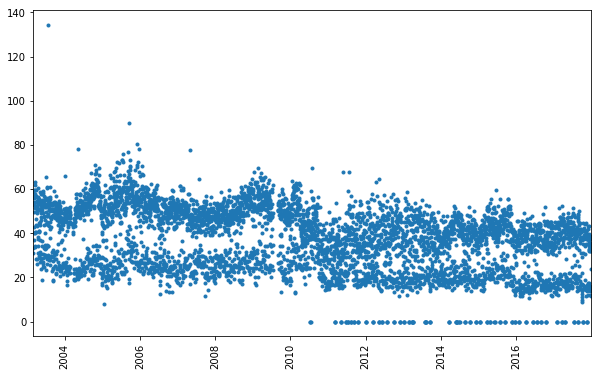

In [7]:
plt.figure(figsize=(10, 6))
df = peopleDf.sort_values('date', ascending=True)
#dfYear = df.loc[df.date.dt.year < 2012]
dfYear = df
plt.plot(dfYear['date'], dfYear['values'], '.')
plt.xticks(rotation='vertical')
plt.xlim(dfYear['date'].values[0], dfYear['date'].values[-1])
plt.show()

# 위의 그래프 무시하고 RNN 인풋 만들기

- 2011년을 기점으로 식사량이 줄어듦
    - 줄어드는 기점을 포함할지 말지 고민할것
- ISSUE
    - 식수인원 부분에 date자체가 누락된 경우가 있음 (74일)
    - RNN input의경우 총길이를 30일이라고 할경우 연속되어야함 따라서 데이터 전처리과정에서 저 누락된부분 처리필요

- 누락된 날짜확인

## 맞춰야하는 날짜 확인

In [8]:
len(peopleDf[peopleDf['values'] == 0])

150

In [9]:
peopleDf[peopleDf['values'] == 0].head()

,date,values
7852,2010-07-13,0.0
7855,2010-07-14,0.0
7858,2010-07-15,0.0
8569,2011-03-09,0.0
8572,2011-03-10,0.0


In [10]:
peopleDfDateidx = pd.DataFrame({'count':peopleDf['values'].values}, index=peopleDf['date'])

In [11]:
peopleDfAllDate = peopleDfDateidx.resample('1D').sum()

In [12]:
len(peopleDfAllDate[peopleDfAllDate['count'] == 0])

227

- 요일정보 추가
- The day of the week with Monday=0, Sunday=6

In [13]:
peopleDfAllDate['weekday'] = peopleDfAllDate.index.weekday
peopleDfAllDate = peopleDfAllDate.reset_index()

In [14]:
peopleDfAllDate[peopleDfAllDate['count'] == 0].index

Int64Index([ 104,  364,  365,  366,  367,  368,  369,  370,  371,  372,
            ...
            5253, 5290, 5291, 5292, 5335, 5336, 5337, 5378, 5379, 5380],
           dtype='int64', length=227)

In [15]:
peopleDfAllDate[peopleDfAllDate['count'] == 0].head()

,date,count,weekday
104,2003-06-13,0.0,4
364,2004-02-28,0.0,5
365,2004-02-29,0.0,6
366,2004-03-01,0.0,0
367,2004-03-02,0.0,1


# 학습/검증 구간 분리

- 총 5420일

In [16]:
# count가  0일인 것만 추출
zero_idx = peopleDfAllDate[peopleDfAllDate['count'] == 0].index

In [17]:
zero_idx

Int64Index([ 104,  364,  365,  366,  367,  368,  369,  370,  371,  372,
            ...
            5253, 5290, 5291, 5292, 5335, 5336, 5337, 5378, 5379, 5380],
           dtype='int64', length=227)

In [18]:
# 시작지점과 끝나는 지점 추출
before_idx = zero_idx[-1]
end_index = [zero_idx[-1]]
start_index = [0]
for i, idx in enumerate(zero_idx):
    if idx != before_idx+1:
        end_index.append(idx)
    if idx-1 != before_idx:
        start_index.append(zero_idx[i-1])
    before_idx = zero_idx[i]
start_index = np.sort(start_index)+1
end_index = np.sort(end_index)-1

* 227개의 식수인원 0이 등장하는데 그중에서 150개가 문제를 위한 식수인원 0, 따라서 그 직전을 맞추는 것이 좋음,
- RNN의 input으로는 30일의 정보가 들어감 -> 따라서 총 66일정도의 버퍼는 있어야 train에 30 맞출 3일, valid에 30 맞출 3일 생김.

In [19]:
# end index 부터 start index 까지 쓰는거, end - start 차가 66보다 작으면 넘어감
use_interval = []
for start, end in zip(start_index, end_index):
    if end-start>66:
        use_interval.append((start, end))

In [20]:
# 
trainDf = []
validDf = []
for i, (start, end) in enumerate(use_interval):
    trainDfTemp = peopleDfAllDate.iloc[start:end-33]
    validDfTemp = peopleDfAllDate.iloc[end-33:end]
    trainDfTemp['orderDf'] = i
    validDfTemp['orderDf'] = i
    trainDf.append(trainDfTemp)
    validDf.append(validDfTemp)
trainDf = pd.concat(trainDf)
validDf = pd.concat(validDf)

d:\00_suhyun_kim\4_dev\dexenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
d:\00_suhyun_kim\4_dev\dexenv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [52]:
trainDf.head(50)

,date,count,weekday,orderDf
1,2003-03-02,33.357401,6,0
2,2003-03-03,58.483755,0,0
3,2003-03-04,59.350181,1,0
4,2003-03-05,52.635379,2,0
5,2003-03-06,40.072202,3,0
6,2003-03-07,49.819495,4,0
7,2003-03-08,42.743682,5,0
8,2003-03-09,36.750903,6,0
9,2003-03-10,53.935018,0,0
10,2003-03-11,56.534296,1,0


In [21]:
trainWindow = []
# Train은 우선 바로앞만 예측하는걸로 학습
for orderIndex in trainDf.orderDf.unique():
    tempArray = trainDf[trainDf.orderDf == orderIndex][['count','weekday']].values
    for i in range(len(tempArray)-31):
        trainWindow.append(tempArray[i:i+31])
        
validWindow = []
for orderIndex in validDf.orderDf.unique():
    tempArray = validDf[validDf.orderDf == orderIndex][['date','count','weekday']].values
    validWindow.append(tempArray)        
        
trainArray = np.array(trainWindow)
validArray = np.array(validWindow)

- 요일정보와 그때의 식수인원을 반영하기위해서 요일은 ohe 한 후, 거기에 식수인원을 곱해서 input을 만들어줌

In [22]:
enc = OneHotEncoder(n_values=7)
trainArrayOhe = enc.fit_transform(trainArray[:, :, 1]).toarray().reshape(-1, 31, 7)*trainArray[:, :, [0]]
validArrayOhe = enc.fit_transform(validArray[:, :, 2]).toarray().reshape(-1, 33, 7)

In [23]:
rnn_config = {
    'ID': 'posco_model',
    'rnn_ID' : 'RNN_model3',
    'n_batch' : 50,
    'n_save' : 1000,
    'n_prt' : 200,
    'n_iter' : 10000,
    'LR' : 0.0003,
    'n_history' : 100,
    'n_input' : 7,
    'n_step' : 30,
    'n_output' : 1,
}


In [24]:
try: 
    os.mkdir('./{}'.format(rnn_config['ID']))
except FileExistsError:
    pass

In [25]:
my_model = RNNmodel(rnn_config)

Model ID : posco_model
Model saved at : ./posco_model/RNN_model3


In [49]:
trainX[0, :3]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 33.35740072],
       [58.48375451,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 59.35018051,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

In [26]:
trainX = trainArrayOhe[:, :30, :]
trainY = np.sum(trainArrayOhe[:, 30:, :], 2)

my_model.fit(trainX, trainY)

199/10001Your loss (200/10000) : 190.18484497070312
399/10001Your loss (400/10000) : 147.0096435546875
599/10001Your loss (600/10000) : 40.886802673339844
799/10001Your loss (800/10000) : 45.260196685791016
999/10001Your loss (1000/10000) : 67.51913452148438
INFO:tensorflow:./posco_model/RNN_model3/checkpoint/RNN_model3_1000 is not in all_model_checkpoint_paths. Manually adding it.
1199/10001Your loss (1200/10000) : 33.70323944091797
1399/10001Your loss (1400/10000) : 47.11909484863281
1599/10001Your loss (1600/10000) : 51.65583038330078
1799/10001Your loss (1800/10000) : 53.94184875488281
1999/10001Your loss (2000/10000) : 58.655452728271484
INFO:tensorflow:./posco_model/RNN_model3/checkpoint/RNN_model3_2000 is not in all_model_checkpoint_paths. Manually adding it.
2199/10001Your loss (2200/10000) : 35.470558166503906
2399/10001Your loss (2400/10000) : 64.60631561279297
2599/10001Your loss (2600/10000) : 27.913503646850586
2799/10001Your loss (2800/10000) : 50.7735595703125
2999/10001

my_model.load('./posco_model/RNN_model1/checkpoint/RNN_model1_9000')

my_model.load('./posco_model/RNN_model2/checkpoint/RNN_model2_4000')

# Predict 1개 하는경우

In [27]:
tempPeopleIn = validArray[:, :30, [1]].copy()
validPeopleTrue = validArray[:, 30:, [1]]
validWeek = validArrayOhe

In [28]:
firstInput = validWeek[:, :30, :]*tempPeopleIn
firstResult = my_model.predict(firstInput)

tempPeopleIn = validArray[:, 1:31, [1]].copy()
tempPeopleIn[:, -1, :] = firstResult
secondInput = validWeek[:, 1:31, :]*tempPeopleIn
secondResult = my_model.predict(secondInput)

tempPeopleIn = validArray[:, 2:32, [1]].copy()
tempPeopleIn[:, -1, :] = secondResult
thirdInput = validWeek[:, 2:32, :]*tempPeopleIn
thirdResult = my_model.predict(thirdInput)

In [29]:
np.sqrt(np.mean(np.square(thirdResult - validPeopleTrue[:, -1, :])))

4.091104378920306

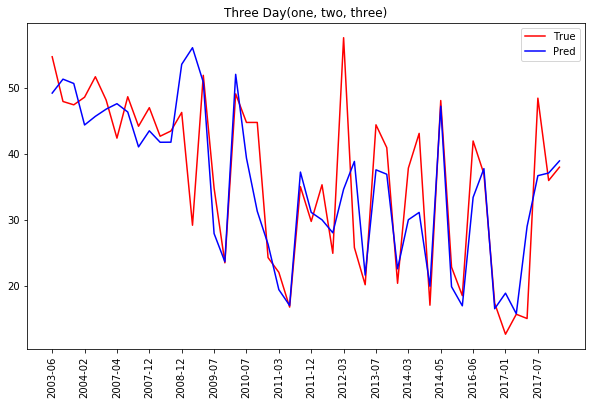

In [40]:
pred_dates = validArray[:, 30:, 0].reshape(-1, 1)
predResult = np.concatenate([firstResult, secondResult, thirdResult], 1)

plt.figure(figsize=(10, 6))
plt.title('Three Day(one, two, three)')
plt.plot(validPeopleTrue.reshape(-1, 1), 'r', label='True')
plt.plot(predResult.reshape(-1), 'b', label='Pred')
plt.legend()
plt.xticks(np.arange(0, 48, 3), pred_dates.astype('datetime64[M]').reshape(-1)[np.arange(0, 48, 3)], rotation='vertical')
plt.savefig('threeday.png')
plt.show()

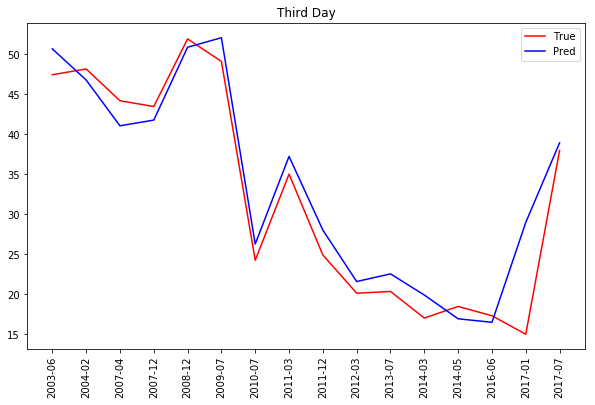

In [42]:
pred_dates = validArray[:, -1, 0].reshape(-1, 1)
predResult = thirdResult

plt.figure(figsize=(10, 6))
plt.title('Third Day')
plt.plot(validPeopleTrue[:, -1].reshape(-1, 1), 'r', label='True')
plt.plot(predResult.reshape(-1), 'b', label='Pred')
plt.legend()
plt.xticks(np.arange(0, 16), pred_dates.astype('datetime64[M]').reshape(-1), rotation='vertical')
plt.savefig('thridday.png')
plt.show()

In [43]:
pred_dates[predResult>validPeopleTrue[:, -1]]

array([Timestamp('2003-06-11 00:00:00'), Timestamp('2009-07-13 00:00:00'),
       Timestamp('2010-07-11 00:00:00'), Timestamp('2011-03-07 00:00:00'),
       Timestamp('2011-12-30 00:00:00'), Timestamp('2012-03-10 00:00:00'),
       Timestamp('2013-07-27 00:00:00'), Timestamp('2014-03-15 00:00:00'),
       Timestamp('2017-01-30 00:00:00'), Timestamp('2017-07-14 00:00:00')],
      dtype=object)

# Predict 3개 하는 경우

tempPeopleIn = validArray[:, :30, [1]].copy()
validPeopleTrue = validArray[:, 30:, [1]]
validWeek = validArrayOhe

firstInput = validWeek[:, :30, :]*tempPeopleIn
predResult = my_model.predict(firstInput)


np.sqrt(np.mean(np.square(predResult[:, -1] - validPeopleTrue[:, -1, :])))

pred_dates = validArray[:, 30:, 0].reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.title('Three Day(one, two, three)')
plt.plot(validPeopleTrue.reshape(-1, 1), 'r', label='True')
plt.plot(predResult.reshape(-1), 'b', label='Pred')
plt.legend()
plt.xticks(np.arange(0, 48, 3), pred_dates.astype('datetime64[M]').reshape(-1)[np.arange(0, 48, 3)], rotation='vertical')
plt.show()

pred_dates = validArray[:, -1, 0].reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.title('Third Day')
plt.plot(validPeopleTrue[:, -1].reshape(-1, 1), 'r', label='True')
plt.plot(predResult[:, -1].reshape(-1), 'b', label='Pred')
plt.legend()
plt.xticks(np.arange(0, 16), pred_dates.astype('datetime64[M]').reshape(-1), rotation='vertical')
plt.show()